# Setup

In [1]:
renv::load("/project/kohl_analysis/analysis/CAdir")
devtools::load_all("/home/kohl/PhD/gits/ClemensKohl/CAdir")

suppressPackageStartupMessages({
  library(scater)
  library(dplyr)
  library(tidyr)
  library(readr)
  library(ggplot2)
  library(ggthemes)
})

dir <- "/project/kohl_analysis/analysis/CAdir/results/results/"
imgdir <- file.path(dir, "img/figure3/")

setwd(dir)
dir.create(imgdir, recursive = TRUE)

options(repr.plot.width = 20, repr.plot.height = 15)

The following package(s) are missing entries in the cache:
- quarto
These packages will need to be reinstalled.

The following package(s) have broken symlinks into the cache:
- quarto
Use `renv::repair()` to try and reinstall these packages.

- The project is out-of-sync -- use `renv::status()` for details.


ℹ Loading CAdir






Warning message in dir.create(imgdir, recursive = TRUE):
“'/project/kohl_analysis/analysis/CAdir/results/results//img/figure3' already exists”


# Cell clustering benchmarking

In [2]:
date <- "20240812"
base_dir <- file.path("/project/kohl_data/CAdir/benchmarking/results/simulated", date)
indir = file.path(base_dir, "eval")

## simulated data
Benchmarking results based on Zeisel Brain data:

In [3]:
zeisel_eval <- readRDS(
  file.path(indir,
  paste0(date, "_zeisel_collated.rds")
  ))

dfz <- zeisel_eval %>%
    mutate(dataset = "zeisel") %>%
    mutate(simulation = paste(dePROB, defacLOC, defacSCALE, sep="_")) %>%
    mutate(simulation = factor(simulation, levels = c('0.02_0.75_0.75',
                                                      '0.06_0.75_0.75',
                                                      '0.1_0.75_0.75',
                                                      '0.02_1.5_1.5',
                                                      '0.06_1.5_1.5',
                                                      '0.1_1.5_1.5')))

table(zeisel_eval$algorithm,
      paste(zeisel_eval$dePROB, zeisel_eval$defacLOC, zeisel_eval$defacSCALE, sep="_"))

                
                 0.02_0.75_0.75 0.02_1.5_1.5 0.06_0.75_0.75 0.06_1.5_1.5
  CAbiNet_igraph            108          108            108          108
  CAdir                     108          108            108          108
  CAdir_auto                108          108            108          108
  Monocle3                  108          104            105          103
  RaceID                    108          108            108          108
  RaceID_auto               108          108            108          108
  SC3                       108          107            108          108
  SIMLR                     108          108            108          108
  Seurat                    108          108            108          108
  kmeans                    108          108            108          108
                
                 0.1_0.75_0.75 0.1_1.5_1.5
  CAbiNet_igraph           108         108
  CAdir                    108         108
  CAdir_auto               108    

Benchmarking results based on PBMC3k data:

In [4]:
pbmc_eval <- readRDS(
  file.path(indir,
  paste0(date, "_pbmc3k_collated.rds")
  ))

dfp <- pbmc_eval %>%
    mutate(dataset = "pbmc3k") %>%
    mutate(simulation = paste(dePROB, defacLOC, defacSCALE, sep="_")) %>%
    mutate(simulation = factor(simulation, levels = c('0.02_0.75_0.75',
                                                      '0.06_0.75_0.75',
                                                      '0.1_0.75_0.75',
                                                      '0.02_1.5_1.5',
                                                      '0.06_1.5_1.5',
                                                      '0.1_1.5_1.5')))

table(pbmc_eval$algorithm,
      paste(pbmc_eval$dePROB, pbmc_eval$defacLOC, pbmc_eval$defacSCALE, sep="_"))

                
                 0.02_0.75_0.75 0.02_1.5_1.5 0.06_0.75_0.75 0.06_1.5_1.5
  CAbiNet_igraph            108          108            108          108
  CAdir                     108          108            108          108
  CAdir_auto                108          108            108          108
  Monocle3                  108          105            105          100
  RaceID                    108          108            108          108
  RaceID_auto               108          108            108          108
  SC3                       108          108            108          108
  SIMLR                     108          108            108          108
  Seurat                    108          108            108          108
  kmeans                    108          108            108          108
                
                 0.1_0.75_0.75 0.1_1.5_1.5
  CAbiNet_igraph           108         108
  CAdir                    108         108
  CAdir_auto               108    

Combining the benchmarking resuls:

In [5]:
df_all <- rbind(dfz, dfp)

df_all$algorithm <- gsub("CAbiNet_igraph", "CAbiNet", df_all$algorithm)

df_all$algorithm <- factor(df_all$algorithm, levels =
                           c("CAdir",
                             "CAdir_auto",
                             "kmeans",
                             "CAbiNet",
                             "RaceID",
                             "RaceID_auto",
                             "Seurat",
                             "Monocle3",
                             "SC3",
                             "SIMLR"))


df <- df_all %>% group_by(simulation, algorithm, dataset) %>%
        mutate(mean_ARI = mean(ARI, na.rm = TRUE)) %>%
        mutate(mean_NMI = mean(NMI, na.rm = TRUE)) %>%
        select(dataset, simulation, algorithm, mean_ARI, mean_NMI) %>%
        distinct() %>%
        ungroup()

### Simulated data benchmarking - Max Results

In [6]:
df <- df_all %>%
    group_by(simulation, algorithm, dataset) %>%
    mutate(max_ARI = max(ARI, na.rm = TRUE)) %>%
    mutate(max_NMI = max(NMI, na.rm = TRUE)) %>%
    select(dataset, simulation, algorithm, max_ARI, max_NMI) %>%
    distinct() %>%
    ungroup()

df$max_ARI[is.infinite(df$max_ARI)] <- 0
df$max_NMI[is.infinite(df$max_NMI)] <- 0

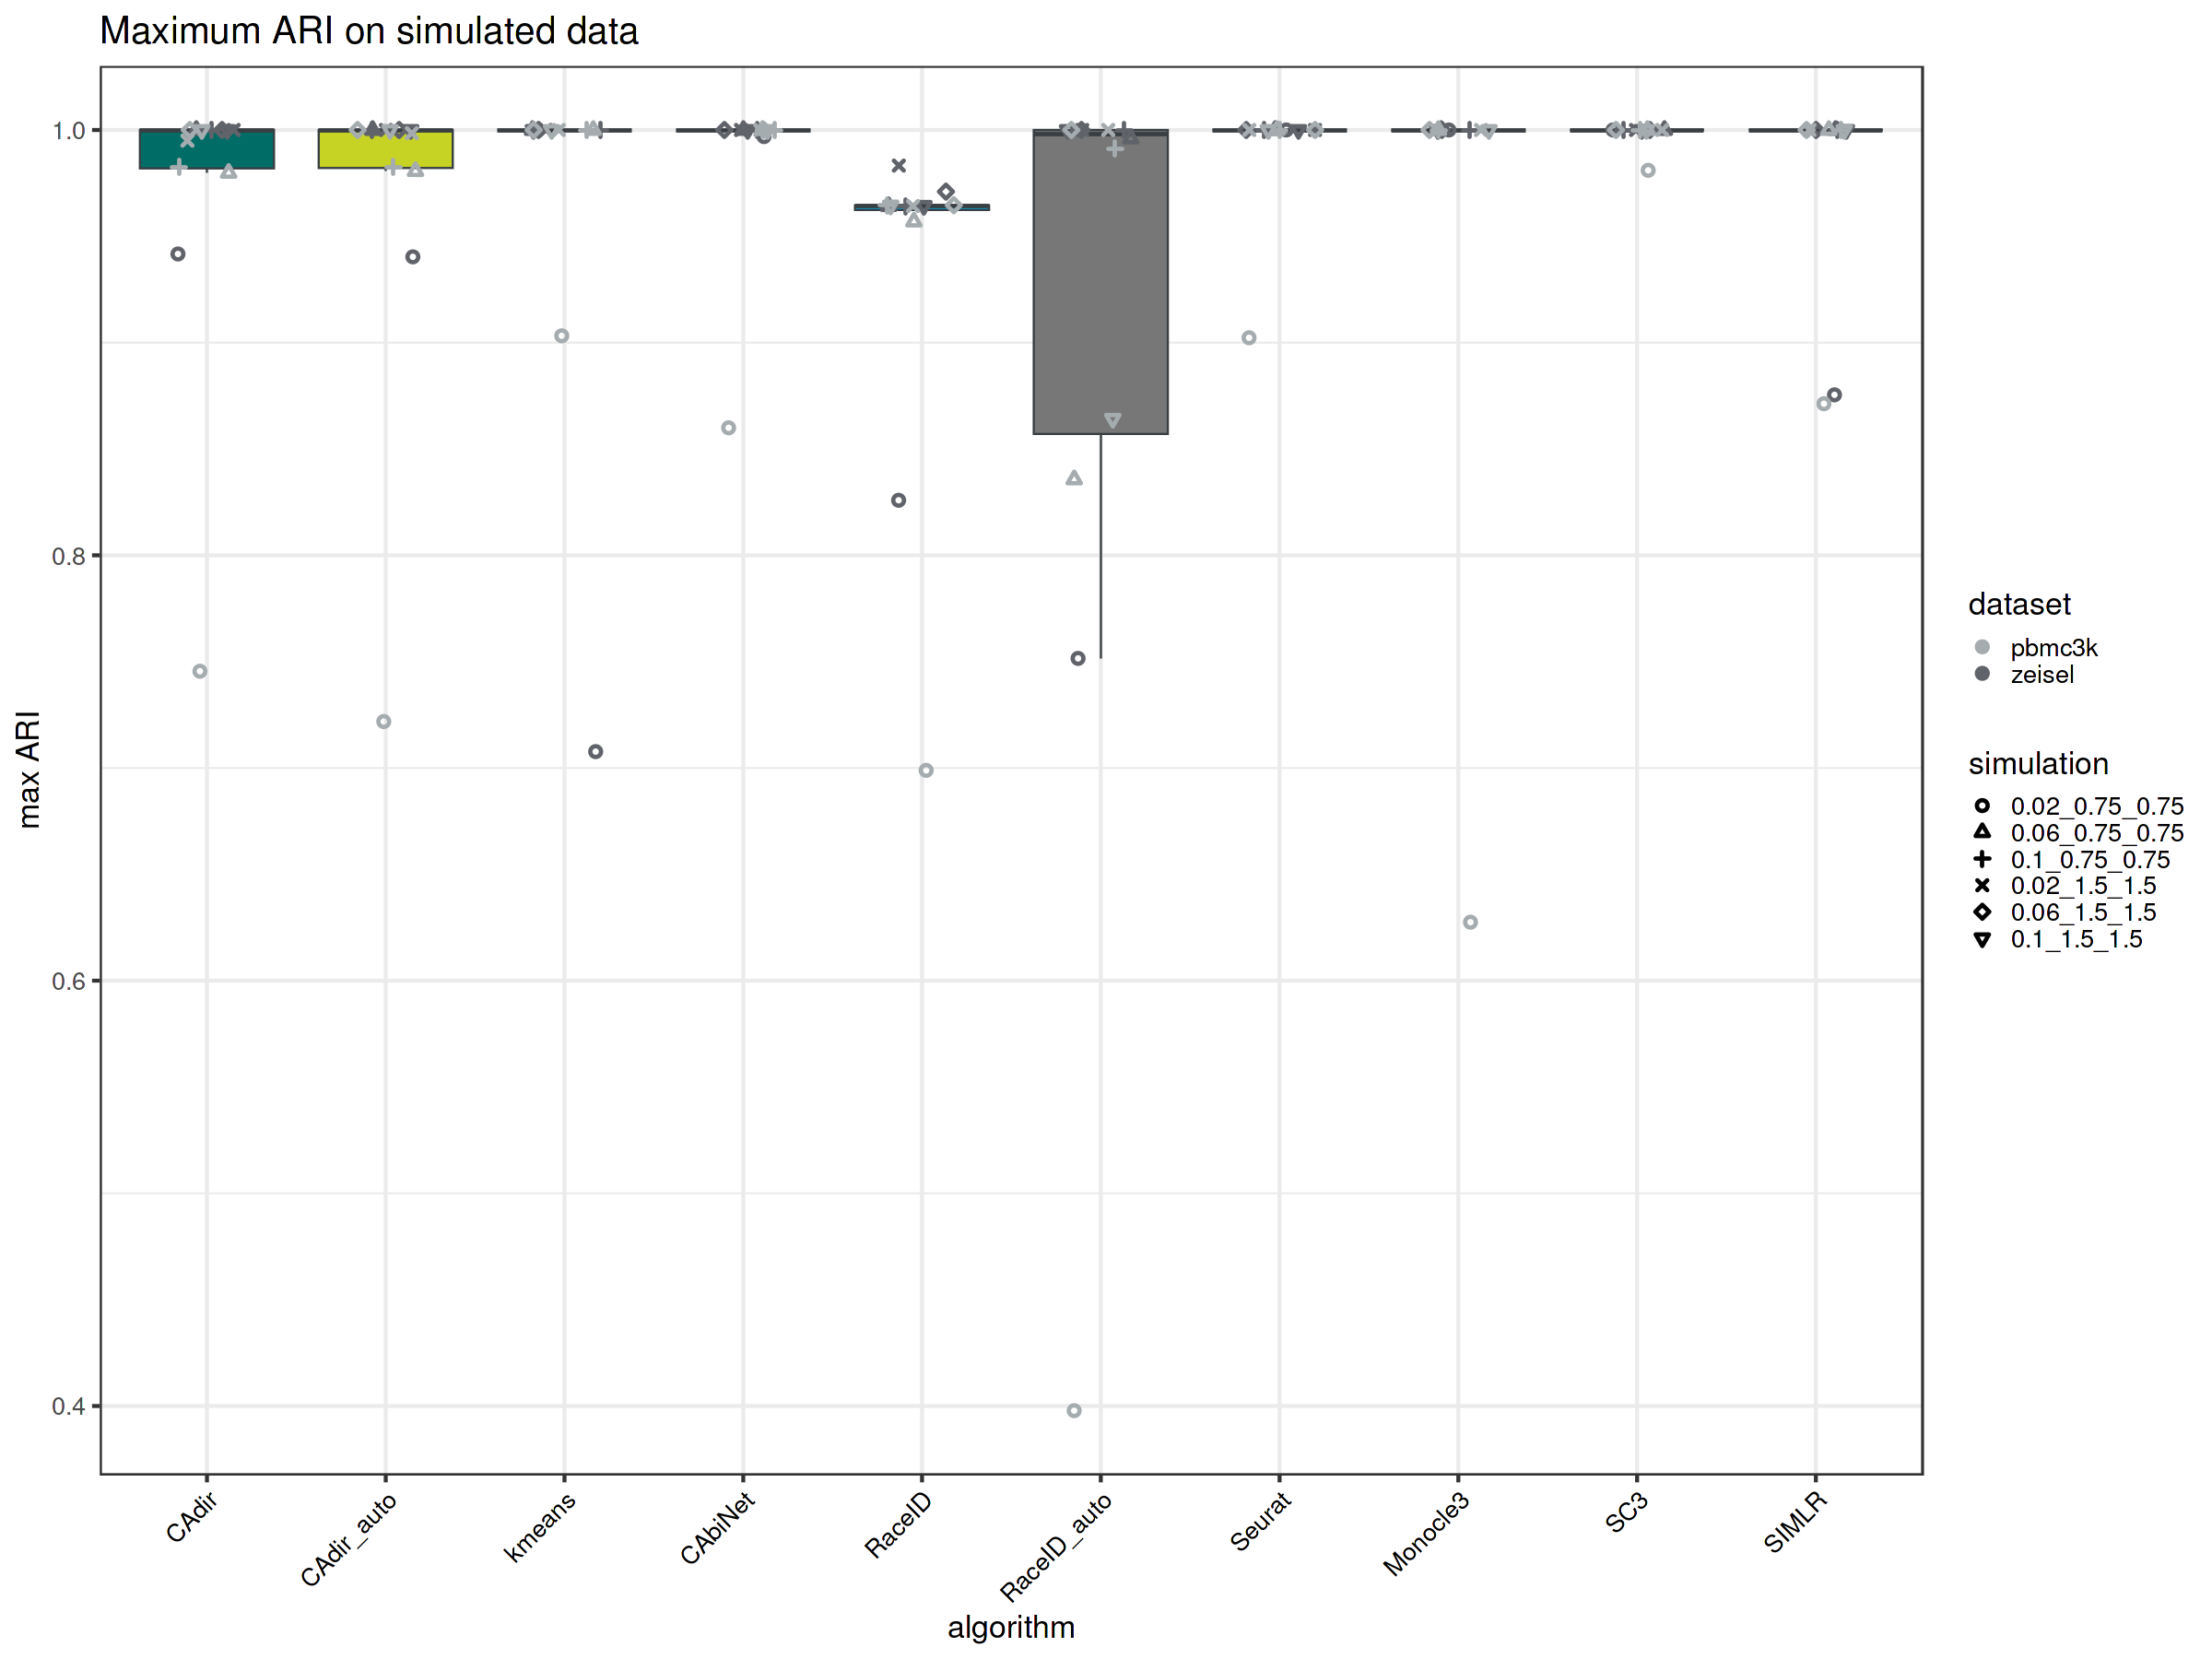

In [7]:
p <- df %>%
ggplot(aes(x=algorithm,
           y=max_ARI)) +
    geom_boxplot(aes(fill = algorithm),
                 color = "#383e42",
                 alpha = 1,
                 outlier.alpha = 0)+
    geom_jitter(aes(x=algorithm,
                    y=max_ARI,
                    color = dataset,
                    group = dataset,
                    shape = simulation),
                    stroke = 1.5,
                    size = 2,
                    width = 0.2) +
    labs(title = "Maximum ARI on simulated data",
         y = "max ARI",
         x = "algorithm") +
    scale_shape_manual(values = seq_len(length(df$simulation))) +
    scale_fill_mpimg(name = "mpi_extend") +
    scale_color_manual(values = list("zeisel" = "#60636a", "pbmc3k" = "#a5acaf")) +
    theme_bw(base_size = 20) +
    theme(
      axis.text.x = element_text(
      color = "black",
      angle = 45,
      vjust = 1,
      hjust=1),
      text = element_text(size = 20),
    ) +
    guides(fill = "none")

p

ggsave(plot = p,
       filename = file.path(imgdir, "sim_bench_max_ARI_cells.pdf"),
       width = 3000,
       height = 2000,
       units = "px")

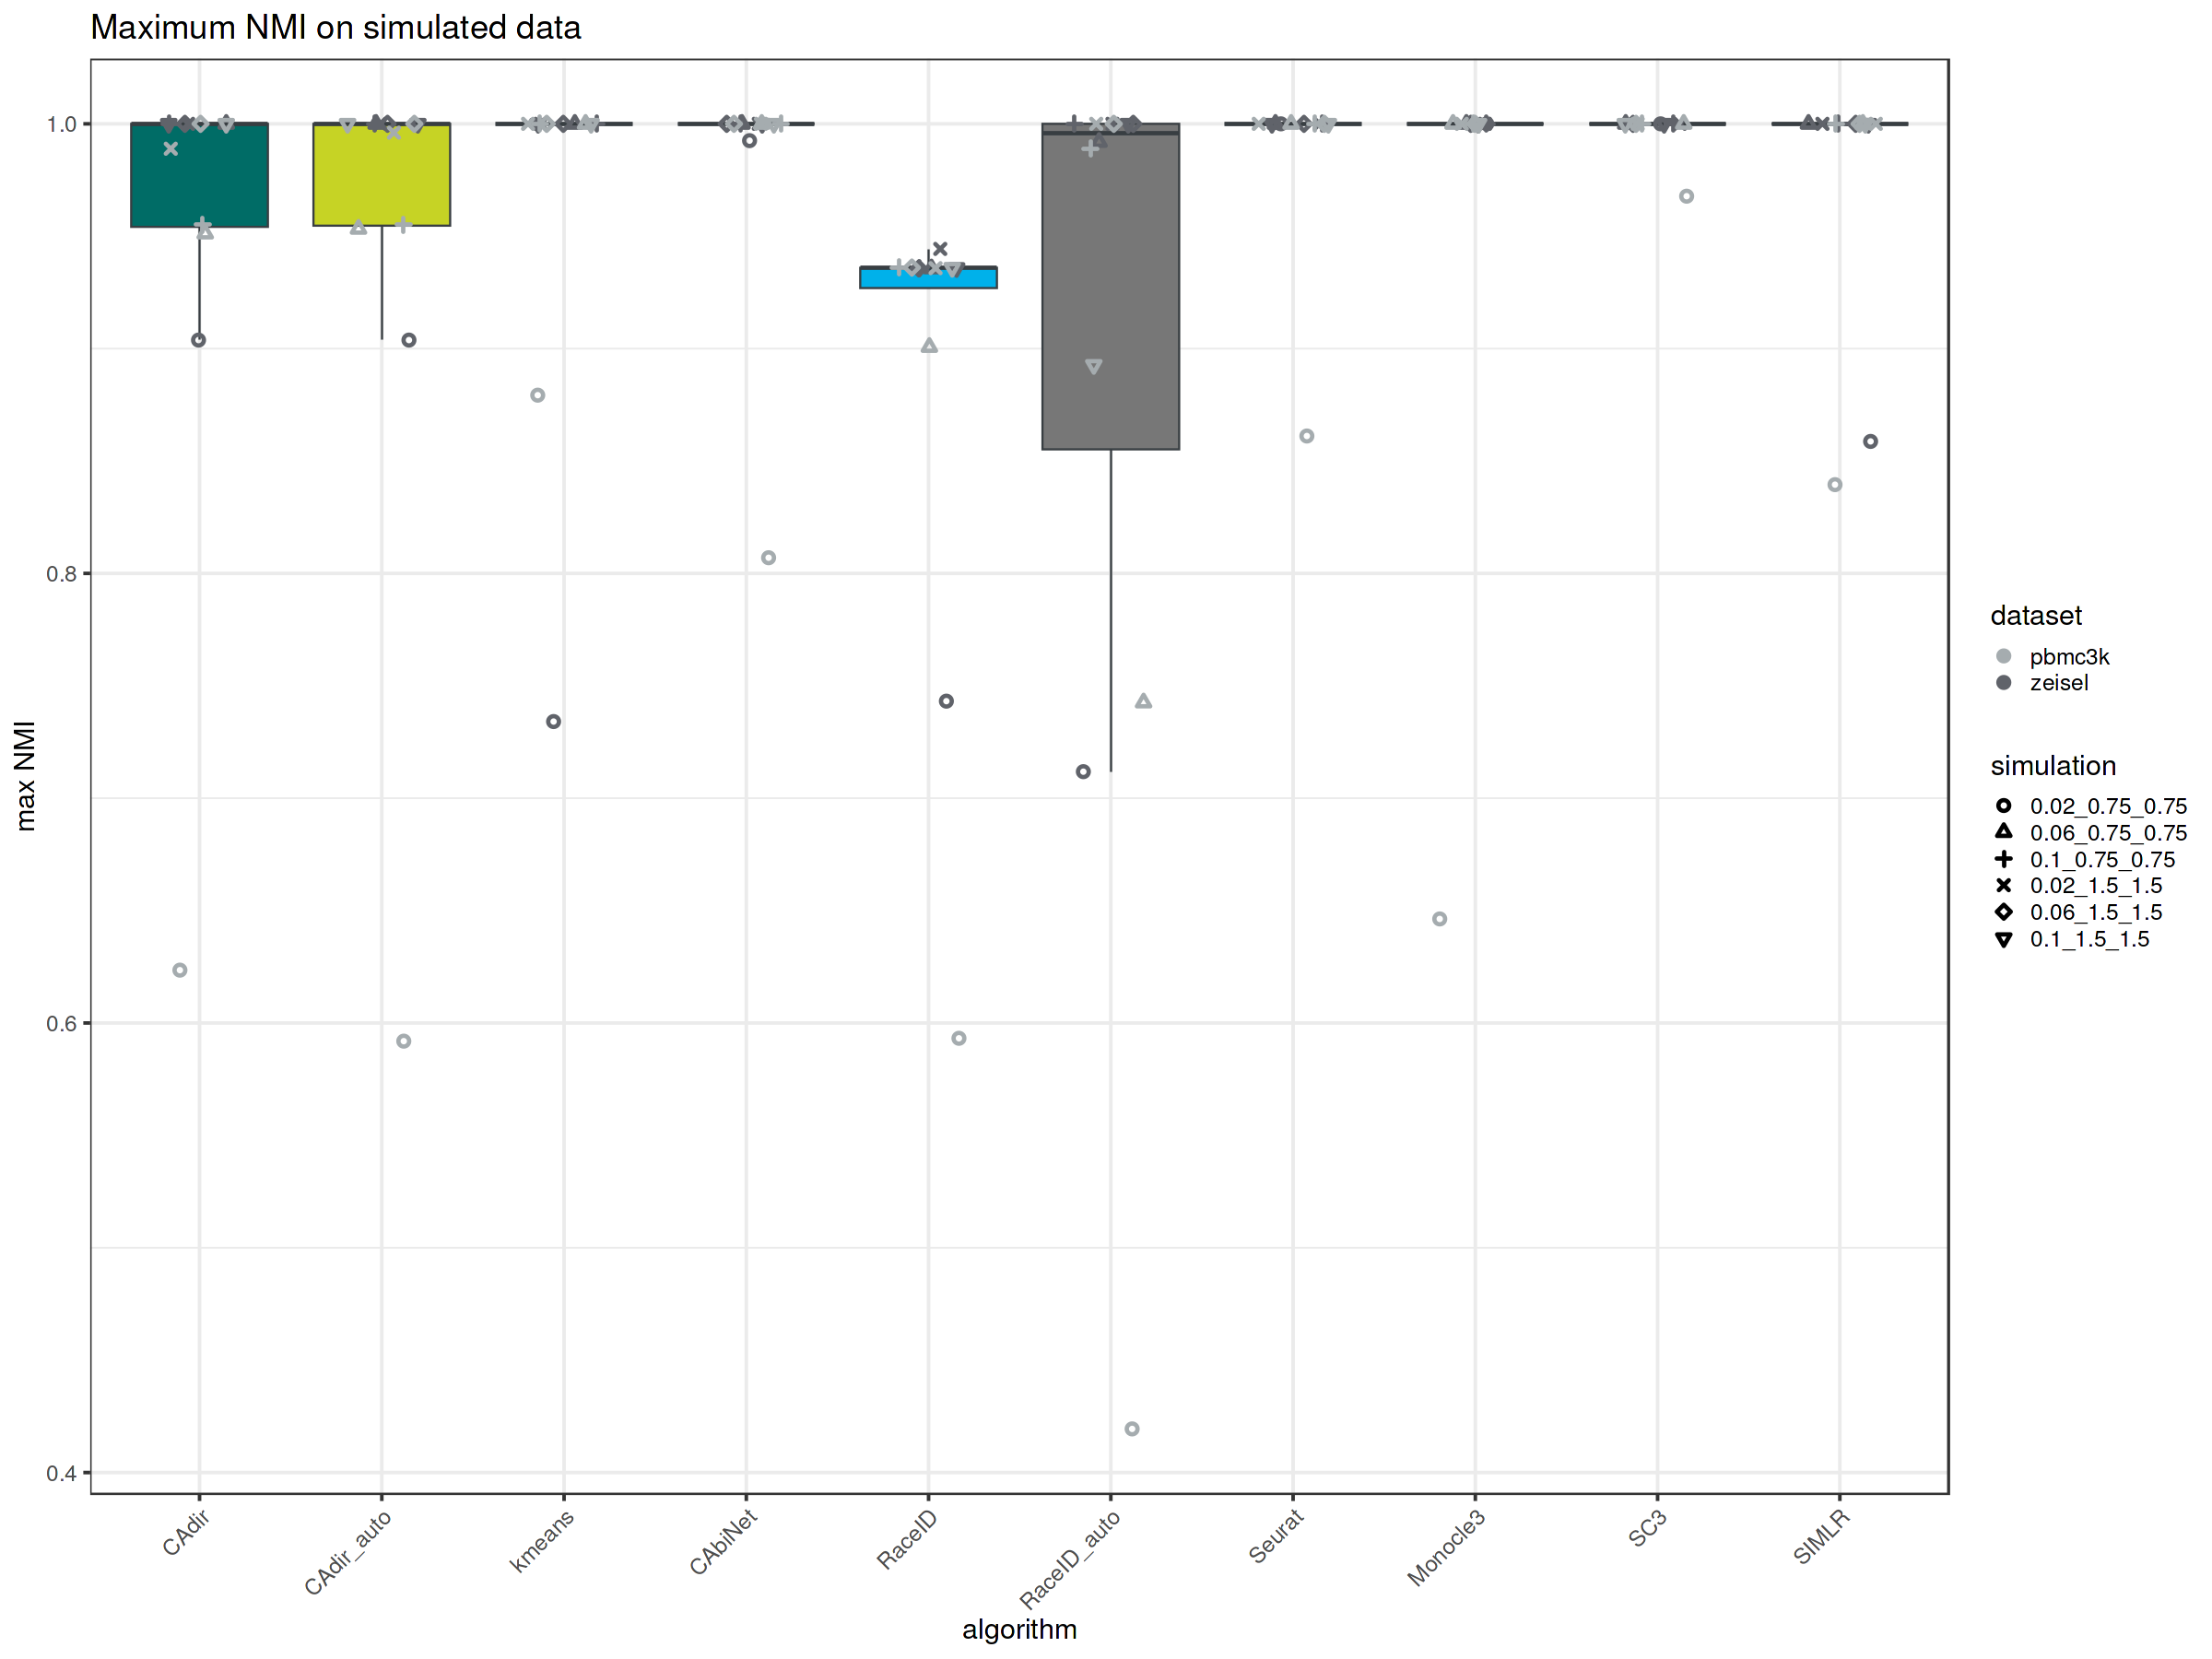

In [8]:
p <- df %>%
ggplot(aes(x=algorithm,
           y=max_NMI)) +
    geom_boxplot(aes(fill = algorithm),
                 color = "#383e42",
                 alpha = 1,
                 outlier.alpha = 0)+
    geom_jitter(aes(x=algorithm,
                    y=max_NMI,
                    color = dataset,
                    group = dataset,
                    shape = simulation),
                    stroke =1.5,
                    size = 2,
                    width = 0.2) +
    labs(title = "Maximum NMI on simulated data",
         y = "max NMI",
         x = "algorithm") +
    scale_shape_manual(values = seq_len(length(df$simulation))) +
    scale_fill_mpimg(name = "mpi_extend") +
    scale_color_manual(values = list("zeisel" = "#60636a", "pbmc3k" = "#a5acaf")) +
    theme_bw(base_size = 18) +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
    guides(fill = "none")

p

ggsave(plot = p,
       filename = file.path(imgdir, "sim_bench_max_NMI_cells.pdf"),
       width = 3000,
       height = 2000,
       units = "px")

### Simulated data benchmarking - Average Results

In [9]:
df <- df_all %>% group_by(simulation, algorithm, dataset) %>%
        mutate(mean_ARI = mean(ARI, na.rm = TRUE)) %>%
        mutate(mean_NMI = mean(NMI, na.rm = TRUE)) %>%
        select(dataset, simulation, algorithm, mean_ARI, mean_NMI) %>%
        distinct() %>%
        ungroup()

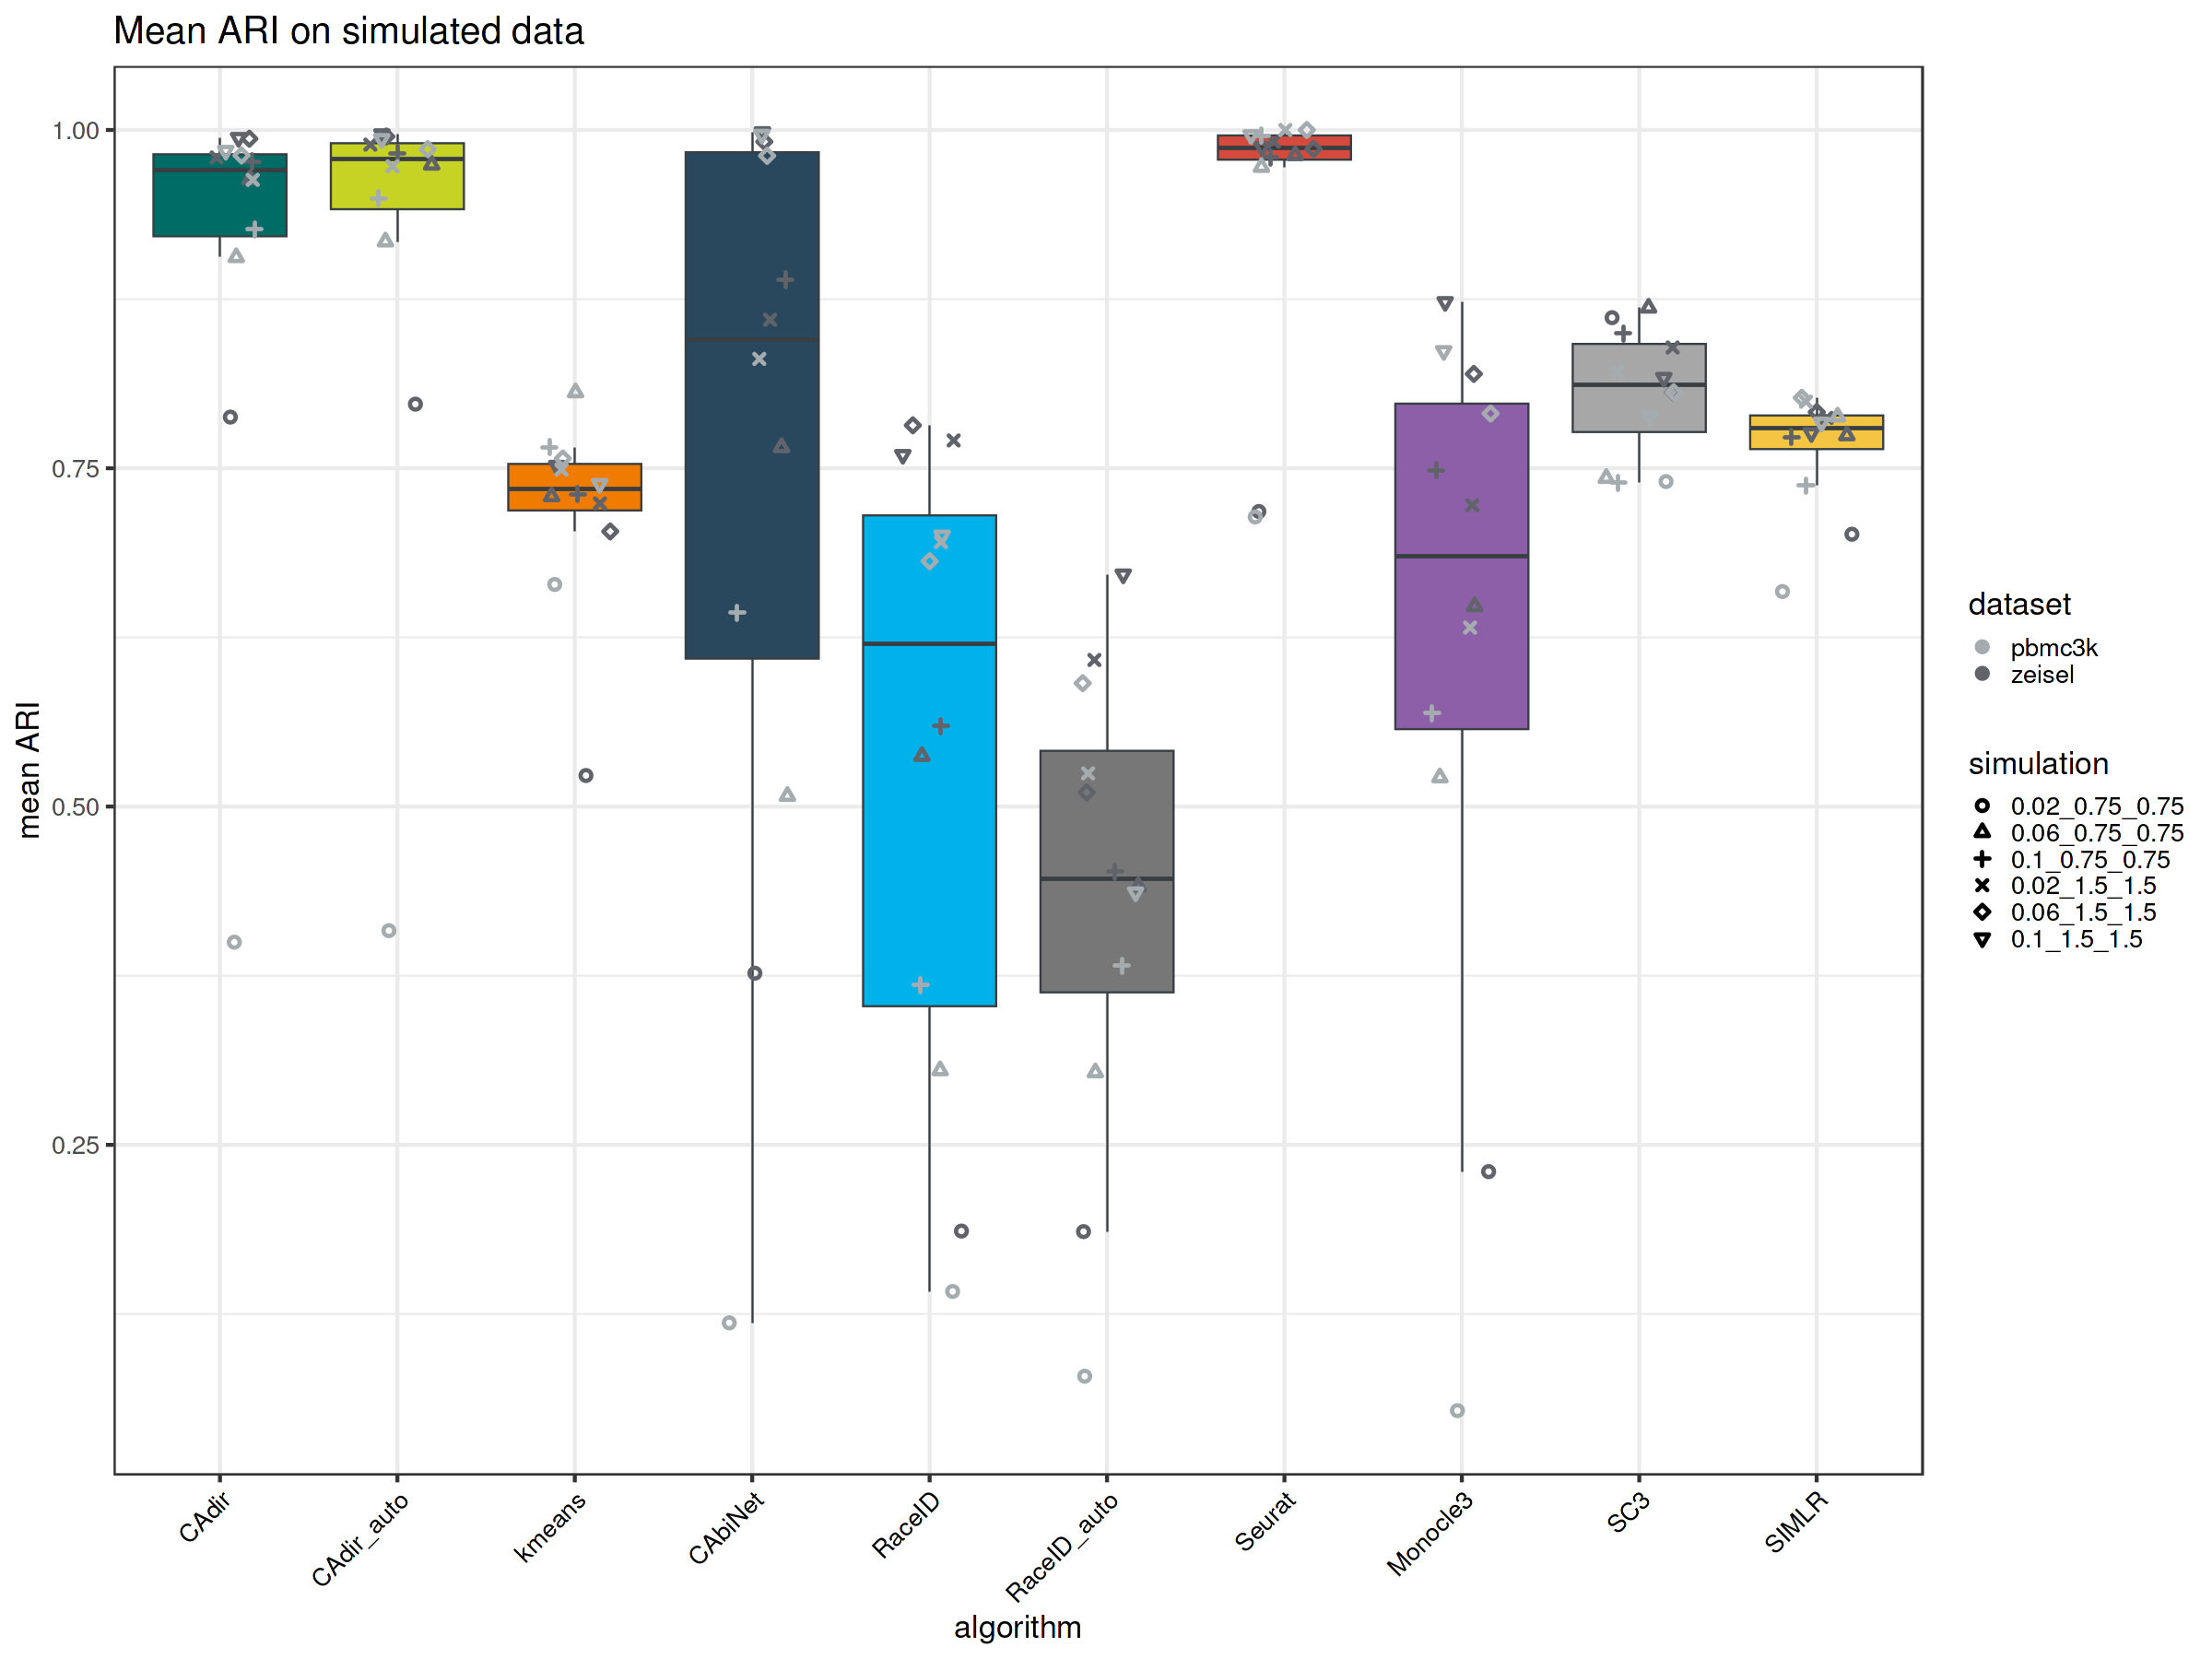

In [10]:
p <- df %>%
ggplot(aes(x=algorithm,
           y=mean_ARI)) +
    geom_boxplot(aes(fill = algorithm),
                 color = "#383e42",
                 alpha = 1,
                 outlier.alpha = 0)+
    geom_jitter(aes(x=algorithm,
                    y=mean_ARI,
                    color = dataset,
                    group = dataset,
                    shape = simulation),
                    stroke =1.5,
                    size = 2,
                    width = 0.2) +
    labs(title = "Mean ARI on simulated data",
         y = "mean ARI",
         x = "algorithm") +
    scale_shape_manual(values = seq_len(length(df$simulation))) +
    scale_fill_mpimg(name = "mpi_extend") +
    scale_color_manual(values = list("zeisel" = "#60636a", "pbmc3k" = "#a5acaf")) +
    theme_bw(base_size = 20) +
    theme(
      axis.text.x = element_text(
      color = "black",
      angle = 45,
      vjust = 1,
      hjust=1),
      text = element_text(size = 20),
    ) +
    guides(fill = "none")

p


ggsave(plot = p,
       filename = file.path(imgdir, "sim_bench_mean_ARI_cells.pdf"),
       width = 2500,
       height = 1650,
       units = "px")

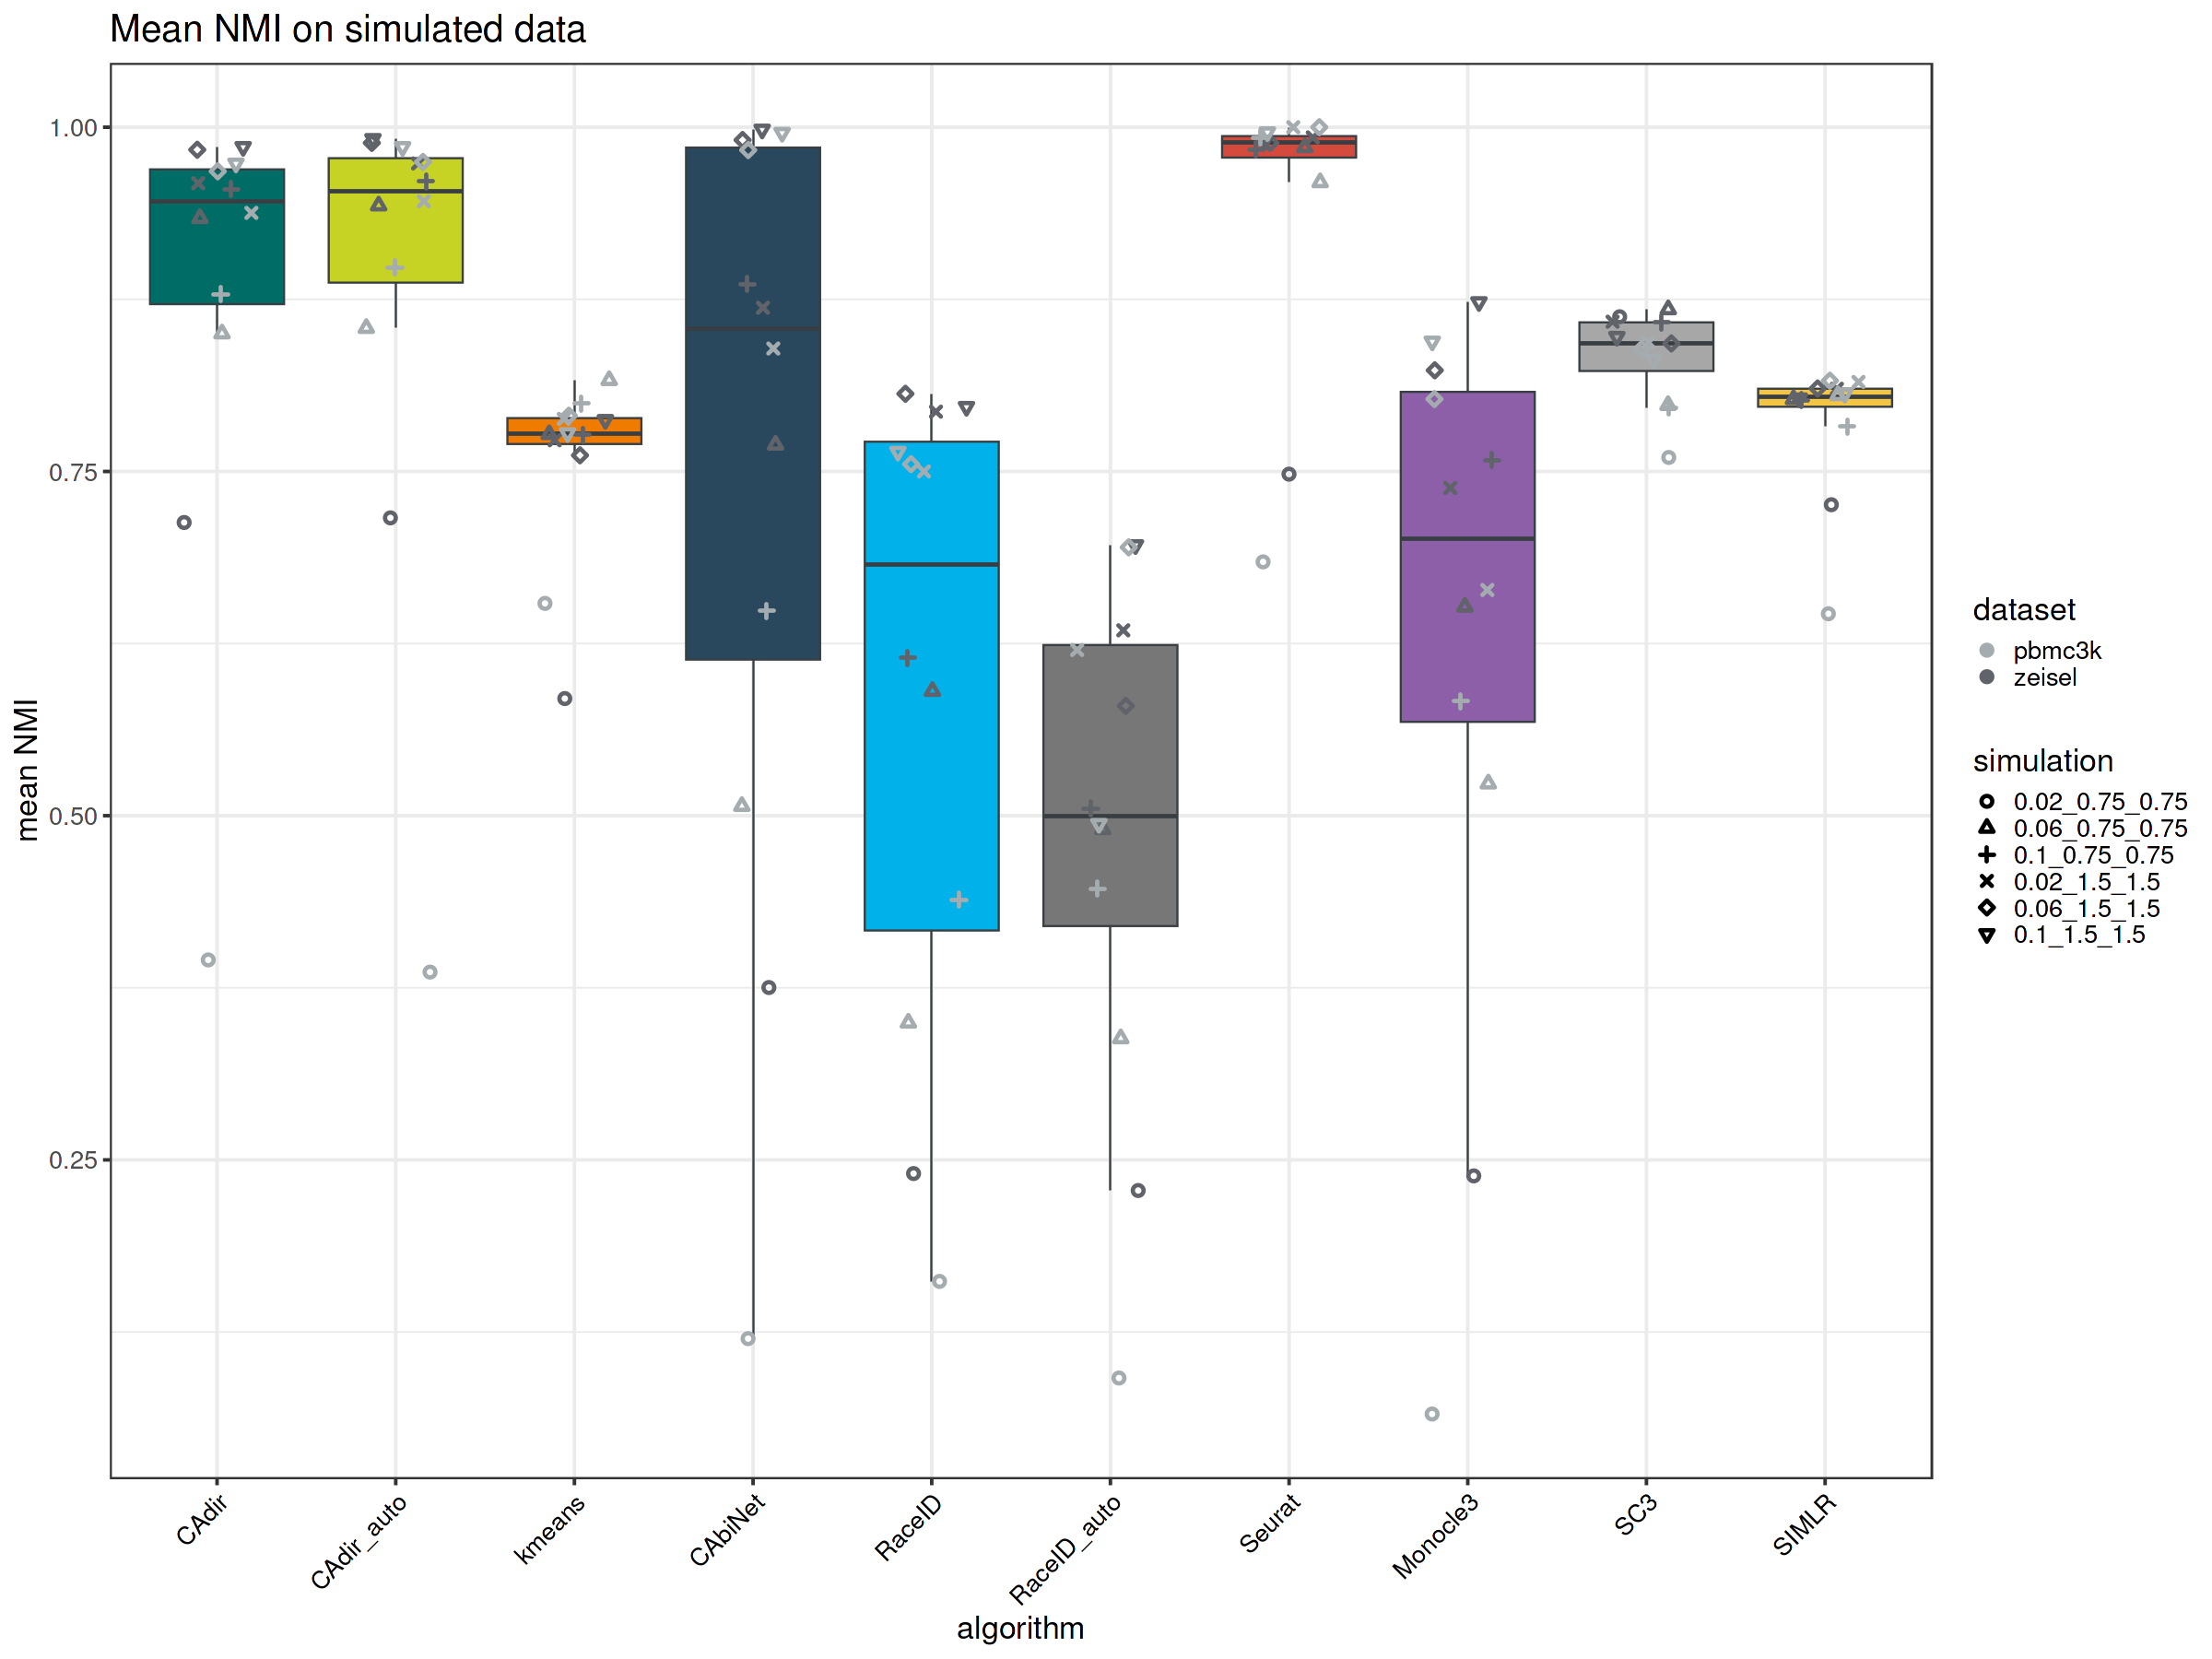

In [11]:
p <- df %>%
ggplot(aes(x=algorithm,
           y=mean_NMI)) +
    geom_boxplot(aes(fill = algorithm),
                 color = "#383e42",
                 alpha = 1,
                 outlier.alpha = 0)+
    geom_jitter(aes(x=algorithm,
                    y=mean_NMI,
                    color = dataset,
                    group = dataset,
                    shape = simulation),
                    stroke =1.5,
                    size = 2,
                    width = 0.2) +
    labs(title = "Mean NMI on simulated data",
         y = "mean NMI",
         x = "algorithm") +
    scale_shape_manual(values = seq_len(length(df$simulation))) +
    scale_fill_mpimg(name = "mpi_extend") +
    scale_color_manual(values = list("zeisel" = "#60636a", "pbmc3k" = "#a5acaf")) +
    theme_bw(base_size = 18) +
    theme(
      axis.text.x = element_text(
      color = "black",
      angle = 45,
      vjust = 1,
      hjust=1),
      text = element_text(size = 20),
    ) +
    guides(fill = "none")

p


ggsave(plot = p,
       filename = file.path(imgdir, "sim_bench_mean_NMI_cells.pdf"),
       width = 2500,
       height = 1650,
       units = "px")

## Experimental Data

In [12]:
date <- "20240812"
evldir = file.path("/project/kohl_data/CAdir/benchmarking/results/real", date, "eval")

options(repr.plot.width = 15, repr.plot.height = 10)

In [13]:
### Load the results of real data sets
files = list.files(evldir, '*.rds', full.names = TRUE)

df = data.frame()
for (file in files){

  data = readRDS(file)
  df = bind_rows(df, data)

}

df$dataset = gsub('_filtered', '', df$dataset)

### Simulated data sets

simdf <- df_all
simdf$dataset = paste0(simdf$dataset, '_', simdf$simulation)

commoncols = intersect(colnames(df), colnames(simdf))

### Merge two data frames
df <- rbind(df[,commoncols], simdf[, commoncols])

In [14]:
df$dataset[df$dataset == "FreytagGold"] = "Freytag Gold"
df$dataset[df$dataset == 'PBMC_10X'] = "PBMC10x"
df$dataset[df$dataset == "Tirosh_nonmaglignant"] = "Tirosh"
df$dataset[df$dataset == "ZeiselBrain"] = "Zeisel"
df$dataset[df$dataset == "BaronPancreas"] = "Baron Pancreas"
df$dataset[df$dataset == "dmel_E14-16h"] = "Dmel Spatial"
df$dataset[df$dataset == "tabula_sapiens_tissue"] = "Tabula Sapiens"
df$dataset[df$dataset == "brain_organoids"] = "Brain Organoids"

df <- df %>%
        mutate(algorithm = gsub("CAbiNet_igraph", "CAbiNet", algorithm)) %>%
        mutate(pattern = paste0(algorithm, dataset))

In [15]:
# Filter out combinations where all runs fail.
test <- df %>%
        group_by(dataset, algorithm) %>%
        mutate(fail.n = sum(is.na(ARI)), scsd.n = n()) %>%
        filter(fail.n == scsd.n | (scsd.n == 0))

## pick 1 algor./dataset combinaton of failed runs
df_na <- test %>%
        group_by(algorithm, dataset) %>%
        arrange(runtime) %>%
        select(-fail.n, -scsd.n) %>%
        top_n(n = 1, wt = runtime)

run_stat = table(df$algorithm, df$dataset)
run_stat

             
              Baron Pancreas Brain Organoids Darmanis Dmel Spatial Freytag Gold
  CAbiNet                108             108      108          108          108
  CAdir                  108             108      108          108          108
  CAdir_auto             108             108      108          108          108
  Monocle3               108             108      106          108          108
  RaceID                 108              83      108          108          108
  RaceID_auto            108              84      108          108          108
  SC3                    108             108      108           54          108
  SIMLR                   20               0      108            0          108
  Seurat                 108             108      108          108          108
  kmeans                 108             108      108          108          108
             
              PBMC10x Tabula Sapiens Tirosh Zeisel pbmc3k_0.02_0.75_0.75
  CAbiNet         1

In [16]:
# Find missing runs (no values because crash/error)

# Find row and column indices of cells equal to 0
zero_indices <- which(run_stat == 0, arr.ind = TRUE)

# Create a data frame with row names and column names
zero_df <- data.frame(
  algorithm = rownames(run_stat)[zero_indices[, 1]],
  dataset = colnames(run_stat)[zero_indices[, 2]]
)

df_na = dplyr::bind_rows(df_na, zero_df)

In [17]:
# Filter out runs which failed
subdf = df[!(df$pattern %in% test$pattern), ]
subdf = subdf[!is.na(subdf$ARI),]
subdf = rbind(subdf, df_na) # add a single instance of failed runs & missing runs.

subdf$algorithm = factor(subdf$algorithm, levels = c(
    "CAdir",
    "CAdir_auto",
    "kmeans",
    "CAbiNet",
    "RaceID",
    "RaceID_auto",
    "Seurat",
    "Monocle3",
    "SC3",
    "SIMLR"
))

df_g <- subdf %>%
    group_by(algorithm, dataset) %>%
    mutate(Mean_ARI = mean(ARI),
           Max_ARI = max(ARI),
           Median_ARI = median(ARI),
           Mean_NMI = mean(NMI),
           Max_NMI = max(NMI))

df_g$dataset = factor(df_g$dataset, levels = c(
    "Darmanis",
    "Freytag Gold",
    "PBMC10x",
    "Tirosh",
    "Zeisel",
    "Baron Pancreas",
    "Dmel Spatial",
    "Tabula Sapiens",
    "Brain Organoids",
    unique(simdf$dataset)
))

In [18]:
df_m <- df_g %>%
    group_by(sim, algorithm, dataset) %>%
    mutate(max_NMI = max(NMI, na.rm = TRUE)) %>%
    mutate(max_ARI = max(ARI, na.rm = TRUE)) %>%
    select(dataset, sim, algorithm, max_NMI, max_ARI) %>%
    distinct() %>%
    ungroup()

df_m$max_NMI[is.infinite(df_m$max_NMI)] <- NA
df_m$max_ARI[is.infinite(df_m$max_ARI)] <- NA

Warning message:
“There were 3 warnings in `mutate()`.
The first warning was:
ℹ In argument: `max_NMI = max(NMI, na.rm = TRUE)`.
ℹ In group 208: `sim = NA`, `algorithm = SIMLR`, `dataset = Dmel Spatial`.
Caused by warning in `max()`:
! no non-missing arguments to max; returning -Inf
ℹ Run `dplyr::last_dplyr_warnings()` to see the 2 remaining warnings.”
Warning message:
“There were 3 warnings in `mutate()`.
The first warning was:
ℹ In argument: `max_ARI = max(ARI, na.rm = TRUE)`.
ℹ In group 208: `sim = NA`, `algorithm = SIMLR`, `dataset = Dmel Spatial`.
Caused by warning in `max()`:
! no non-missing arguments to max; returning -Inf
ℹ Run `dplyr::last_dplyr_warnings()` to see the 2 remaining warnings.”


In [19]:
options(repr.plot.width=10, repr.plot.height=5)

# Remove simulated data sets
df_real <- df_g %>% filter(dataset %in% c(
    "Darmanis",
    "Freytag Gold",
    "PBMC10x",
    "Tirosh",
    "Zeisel",
    "Baron Pancreas",
    "Dmel Spatial",
    "Tabula Sapiens",
    "Brain Organoids"
) )
df_real$dataset = droplevels(df_real$dataset)
df_real <- df_real %>%
    drop_na(algorithm) %>%
    droplevels()

na_txt <- df_real[is.na(df_real$Max_ARI), ]
na_txt$NAs <- as.character("N/A")

In [20]:
df_tile <- df_real %>%
  select(algorithm, dataset, Max_ARI) %>%
  distinct() %>%
  group_by(dataset) %>%
  mutate(ismax = (round(Max_ARI,2) == max(round(pick(Max_ARI),2), na.rm = TRUE))) %>%
  mutate(is2nd = (round(Max_ARI, 2) == round(
    sort(Max_ARI, decreasing = TRUE, na.last = NA)[2],
    2))) %>%
  ungroup() %>%
  arrange(desc(ismax))

df_tile$ismax[is.na(df_tile$ismax)] <- FALSE
df_tile$is2nd[is.na(df_tile$is2nd)] <- FALSE

Warning message:
“Removed 3 rows containing missing values or values outside the scale range (`geom_text()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range (`geom_text()`).”


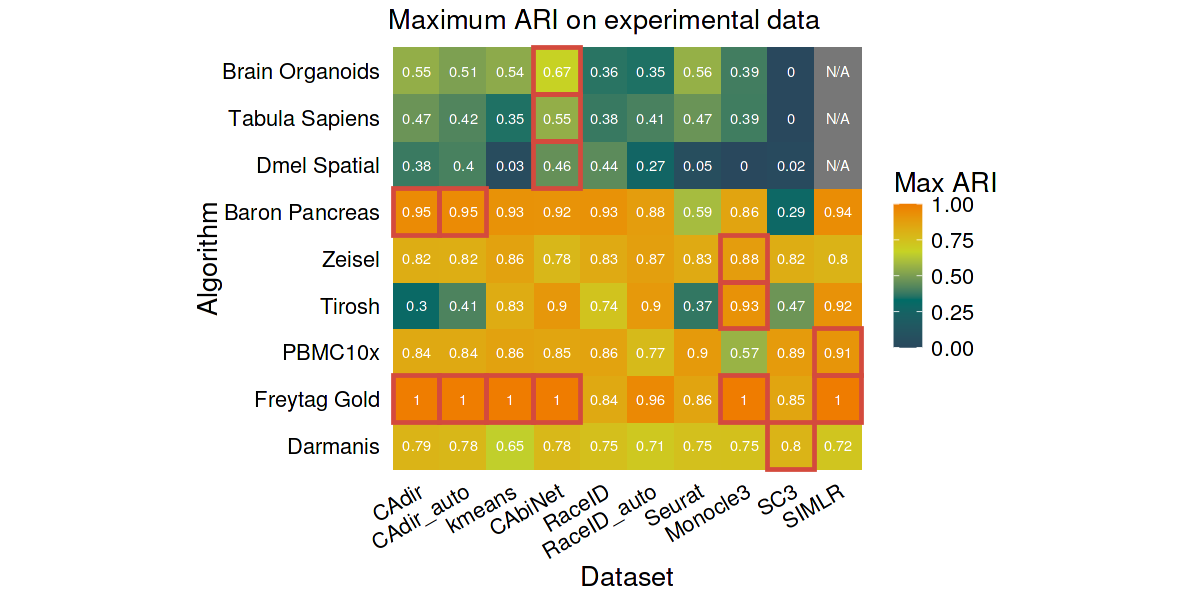

In [21]:
p <- ggplot(df_tile, aes(x = algorithm, y = dataset, fill = Max_ARI)) +
  geom_tile() +
  geom_tile(data = df_tile[df_tile$ismax, ],
    aes(x = algorithm, y = dataset),
    fill = NA,
    color = "#d44a3d",
    linewidth = 1) +
  # geom_tile(data = df_tile[df_tile$is2nd & !df_tile$ismax, ],
  #   aes(x = algorithm, y = dataset),
  #   fill = NA,
  #   color = "#8c5fa8",
  #   size = 1) +
  geom_text(
    aes(label = round(Max_ARI, 2)),
    color = "white",
    size = 3,
    check_overlap = T,
  ) +
  geom_text(
    data = na_txt,
    aes(x = algorithm, y = dataset, label = NAs),
    color = "white",
    size = 3,
    check_overlap = T
  ) +
  scale_fill_gradientn(
    colours = c("#29485d", "#006c66", "#c6d325", "#ef7c00"),
    limits = c(0, 1),
    na.value="#777777",
    name = "Max ARI"
  ) + 
  scale_color_manual(values = c("transparent", "red")) +
  coord_fixed() +
  theme_minimal() +
  theme(panel.border = element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.background = element_blank(),
    axis.text.y = element_text(color = "black"),
    axis.text.x = element_text(angle = 30, hjust = 1, color = "black"),
    text = element_text(size = 16),
    plot.title = element_text(size = 16, face = "plain")) +
  labs(x = 'Dataset', y = 'Algorithm', title = "Maximum ARI on experimental data")

p

ggsave(plot = p,
       filename = file.path(imgdir, "real_bench_max_ARI_cells.pdf"),
        width = 2000,
        height = 1750,
       units = "px")

## Calculate % successful runs

In [22]:
n_param <- 108

stats <- df %>%
group_by(algorithm, dataset) %>%
mutate(n_runs = n(),
       NA_ARI = sum(is.na(ARI)),
       NA_NMI = sum(is.na(NMI))) %>%
mutate(perc_ARI_succ = round((n_runs - NA_ARI) / n_param, 2),
       perc_NMI_succ = round((n_runs - NA_NMI) / n_param, 2),
       perc_ARI_NA = round(NA_ARI / n_param, 2),
       perc_NMI_NA = round(NA_NMI / n_param, 2),
       perc_crash = round((n_param - n_runs) / n_param, 2)) %>%
select(algorithm, dataset, perc_ARI_succ, perc_NMI_succ, perc_ARI_NA, perc_NMI_NA, perc_crash) %>%
distinct()

In [23]:
stats$algorithm = factor(stats$algorithm, levels = c(
    "CAdir",
    "CAdir_auto",
    "kmeans",
    "CAbiNet",
    "RaceID",
    "RaceID_auto",
    "Seurat",
    "Monocle3",
    "SC3",
    "SIMLR"
))

stats$dataset = factor(stats$dataset, levels = c(
  "Darmanis",
  "Freytag Gold",
  "PBMC10x",
  "Tirosh",
  "Zeisel",
  "Baron Pancreas",
  "Dmel Spatial",
  "Tabula Sapiens",
  "Brain Organoids",
  unique(simdf$dataset)
))

In [24]:
all_comb <- crossing(algorithm = stats$algorithm, dataset = stats$dataset) %>%
    mutate(comb = paste0(algorithm, "_", dataset))

comb_in_data <- stats %>%
    mutate(comb = paste0(algorithm, "_", dataset)) %>%
    pull(comb)

not_in_data <- which(!all_comb$comb %in% comb_in_data)

missing_comb <- all_comb[not_in_data, ]
missing_comb <- missing_comb %>%
    select(algorithm, dataset) %>%
    mutate(perc_ARI_succ = 0,
           perc_NMI_succ = 0,
           perc_ARI_NA = 0,
           perc_NMI_NA = 0,
           perc_crash = 1)

stats <- bind_rows(stats, missing_comb)

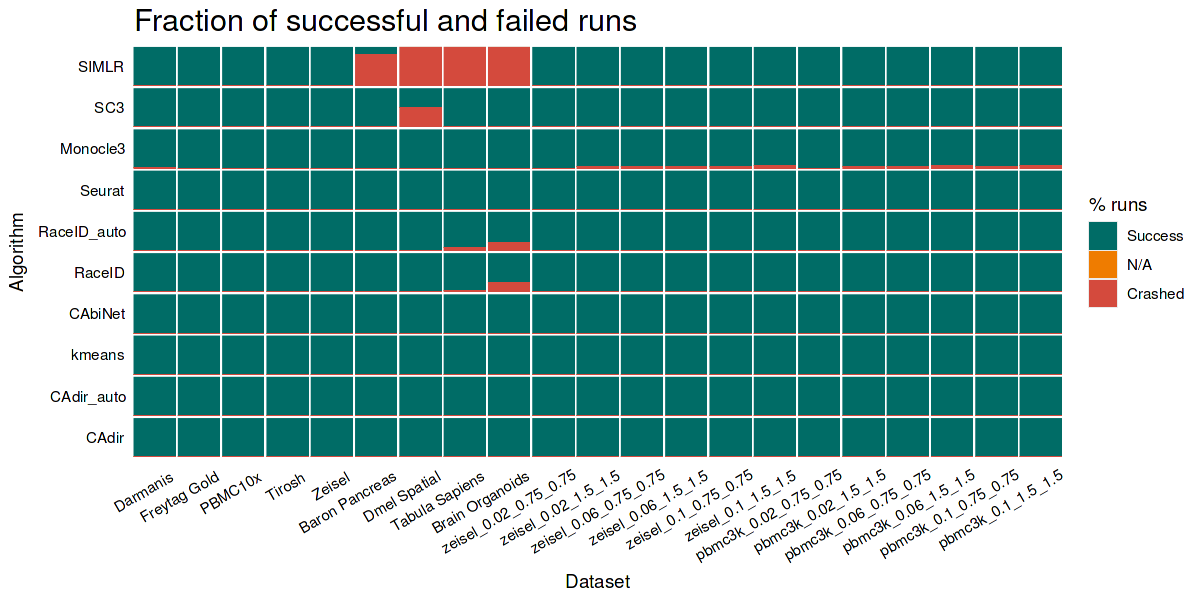

In [25]:
p <- stats %>%
  distinct() %>%
  select(-perc_NMI_succ, -perc_NMI_NA) %>%
  pivot_longer(cols = starts_with("perc"), names_to = "stat", values_to = "perc") %>%
  mutate(stat = factor(stat, levels = c("perc_ARI_succ", "perc_ARI_NA", "perc_crash"))) %>%
  ggplot(aes(x = 1, y = perc, fill = stat )) +
  geom_col(position = "fill") +
  facet_grid(algorithm ~ dataset, as.table = FALSE, switch = "both") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_continuous(expand = c(0, 0)) +
  theme(panel.grid = element_blank(),
    axis.ticks = element_blank(),
    axis.text = element_blank(),
    strip.background = element_blank(),
    strip.text.x = element_text(angle = 30,
      hjust = 0.95,
      vjust = 0.9,
      color = "black"),
    strip.text.y.left = element_text(angle = 0,
      hjust = 0.95,
      color = "black"),
    strip.clip = "off",
    text = element_text(size=11),
    panel.spacing = unit(1.5, "pt"),
    plot.title = element_text(size = 18)
  ) +
  scale_fill_manual(values = c("perc_ARI_succ" = "#006c66", "perc_ARI_NA" = "#ef7c00", "perc_crash" = "#d44a3d"),
    name = "% runs",
    labels = c("Success", "N/A", "Crashed") ) +
  ggtitle("Fraction of successful and failed runs") +
  xlab("Dataset") +
  ylab("Algorithm")

ggsave(plot = p,
       filename = file.path(imgdir, "barplots_fraction_successful_runs_ARI_wide.pdf"),
       width = 8, height = 4.2)
p

# Runtime & Scalability

In [26]:
date = "20240812"
mpgGreen = "#006c66"
mpgDarkGreen = "#005555"
mpgDarkGrey = "#777777"
mpgGreenLight = "#c6d325"
mpgOrange = '#ef7c00'
mpgGrau = "#a7a7a8" # MPG-Grau
mpgDarkBlue = "#29485d" # MPG Dunkelblau
mpgLightBlue = "#00b1ea" # MPG Hellblau

eval_files = list.files(
  file.path("/project/kohl_data/CAdir/benchmarking/results/scalability", date, "out"),
  pattern = '*.csv',
  full.names = T
)


scal_df = data.frame()
for (f in eval_files){
    df = read_csv(f, progress = FALSE, show_col_types = FALSE)
    suppressWarnings({
      scal_df <- dplyr::bind_rows(scal_df, df)
  })
}

scal_df$dataset = gsub('_ngene-2000', '', scal_df$dataset)
scal_df$dataset = gsub('ncell-', '', scal_df$dataset)
scal_df$algorithm = gsub('CAbiNet_igraph', 'CAbiNet', scal_df$algorithm)

scal_df$algorithm <- factor(scal_df$algorithm, levels = c(
    "CAdir",
    "CAdir_auto",
    "kmeans",
    "CAbiNet",
    "RaceID",
    # "RaceID_auto",
    "Seurat",
    "Monocle3",
    "SC3",
    "SIMLR"
))

scal_df$dataset = as.numeric(scal_df$dataset)

scal_df <- scal_df[!is.na(scal_df$algorithm), ]

scal_df$total_runtime <- scal_df$runtime + ifelse(is.na(scal_df$runtime_dimreduc), yes = 0, no = scal_df$runtime_dimreduc)
table(scal_df$algorithm)


     CAdir CAdir_auto     kmeans    CAbiNet     RaceID     Seurat   Monocle3 
        10          0         10          7          2         10          7 
       SC3      SIMLR 
        10          1 

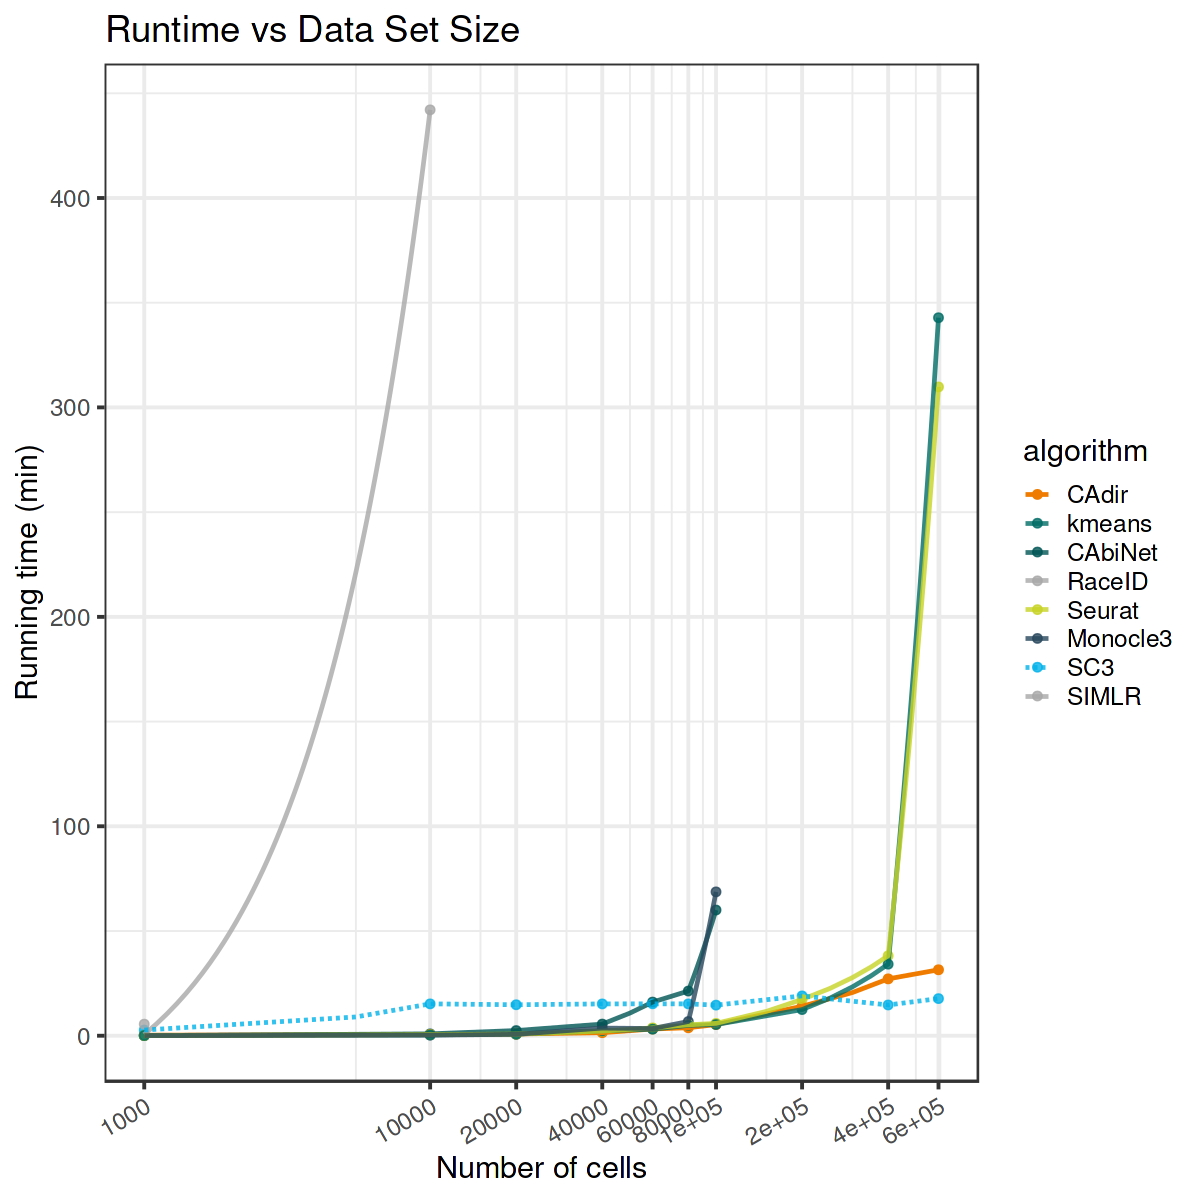

In [27]:
options(repr.plot.width = 10, repr.plot.height = 10)

alph <- 0.8
rt <- ggplot(scal_df, aes(dataset,  (total_runtime/60))) +
geom_point(aes(group = algorithm, color = algorithm, alpha = algorithm), size = 2) +
geom_line(aes(group = algorithm, color = algorithm, alpha = algorithm, linetype = algorithm), linewidth = 1 )+
    scale_x_continuous(breaks = c( 1000,
                                  10000,
                                  20000,
                                  40000,
                                  60000,
                                  80000,
                                  100000,
                                  200000,
                                  400000,
                                  600000),
                       labels = c( '1000',
                                   '10000',
                                   '20000',
                                   '40000',
                                    '60000',
                                   '80000',
                                   '1e+05',
                                   '2e+05',
                                   '4e+05',
                                   '6e+05'
                                  )) +
labs(x = 'Number of cells', y = 'Running time (min)', title = "Runtime vs Data Set Size") +
coord_trans(x="log10") +
scale_alpha_manual(values = c(
    'CAdir' = 1,
    'CAbiNet' = alph,
    'Monocle3' = alph,
    'RaceID' = alph,
    # 'RaceID_auto' = alph,
    'SC3' = alph,
    'SIMLR' = alph,
    'Seurat' = alph,
    'kmeans' = alph
)) +
scale_colour_manual(values = c(
    'CAdir' = mpgOrange,
    'CAbiNet' = mpgDarkGreen,
    'Monocle3' = mpgDarkBlue,
    'RaceID' = mpgGrau,
    # 'RaceID_auto' = alph,
    'SC3' = mpgLightBlue,
    'SIMLR' = mpgGrau,
    'Seurat' = mpgGreenLight,
    'kmeans' = mpgGreen
)) +
scale_linetype_manual(values = c(
    'CAdir' = "solid",
    'CAbiNet' = "solid",
    'Monocle3' = "solid",
    'RaceID' = "solid",
    # 'RaceID_auto' = "solid",
    'SC3' = "dashed",
    'SIMLR' = "solid",
    'Seurat' = "solid",
    'kmeans' = "solid"
  )) +
theme_bw(base_size = 18) +
theme(axis.text.x = element_text(angle = 30, vjust = 1, hjust=1))

rt

ggsave(
  plot = rt,
  filename = file.path(imgdir, "runtime_singleproc.pdf"),
  width = 2200,
  height = 1800,
  units = "px"
)

# Detection of cluster number

In [28]:
date = "20240812"
indir <- "/project/kohl_data/CAdir/benchmarking/results/ct_detection"

if (file.exists(file.path(indir, date, "eval", "results.csv"))) {
  # If only a single file:
  res <- read_csv(file.path(indir, date, "eval", "results.csv"),
    show_col_types = FALSE,
    progress = FALSE)
} else {
  # For multiple split files.
  files <- list.files(path = file.path(indir, date, "out"), pattern = "*.csv", full.names = TRUE)

  res <- tibble()
  for (f in files) {
    tmp <- read_csv(file = f, show_col_types = FALSE, progress = FALSE)
    tmp$file <- basename(f)
    res <- bind_rows(res, tmp)
  }

  dir.create(file.path(indir, date, "eval"), recursive = TRUE)
  write_csv(res, file = file.path(indir, date, "eval", "results.csv"))

}

In [29]:
res <- res %>%
  mutate(diff_abs = cts_found-nr_cts) %>%
  mutate(diff_perc = cts_found/nr_cts) %>%
  mutate(log2fc = log2(cts_found/nr_cts)) %>%
  mutate(apl_q = as.factor(apl_q)) %>%
  mutate(k = as.factor(k))

res <- res %>%
  group_by(nr_cts, k, apl_q) %>%
  mutate(diff_mean = mean(diff_abs)) %>%
  mutate(diff_sd = sd(diff_abs)) %>%
  mutate(log2fc_mean = mean(log2fc)) %>%
  mutate(log2fc_sd = sd(log2fc)) %>%
  ungroup()

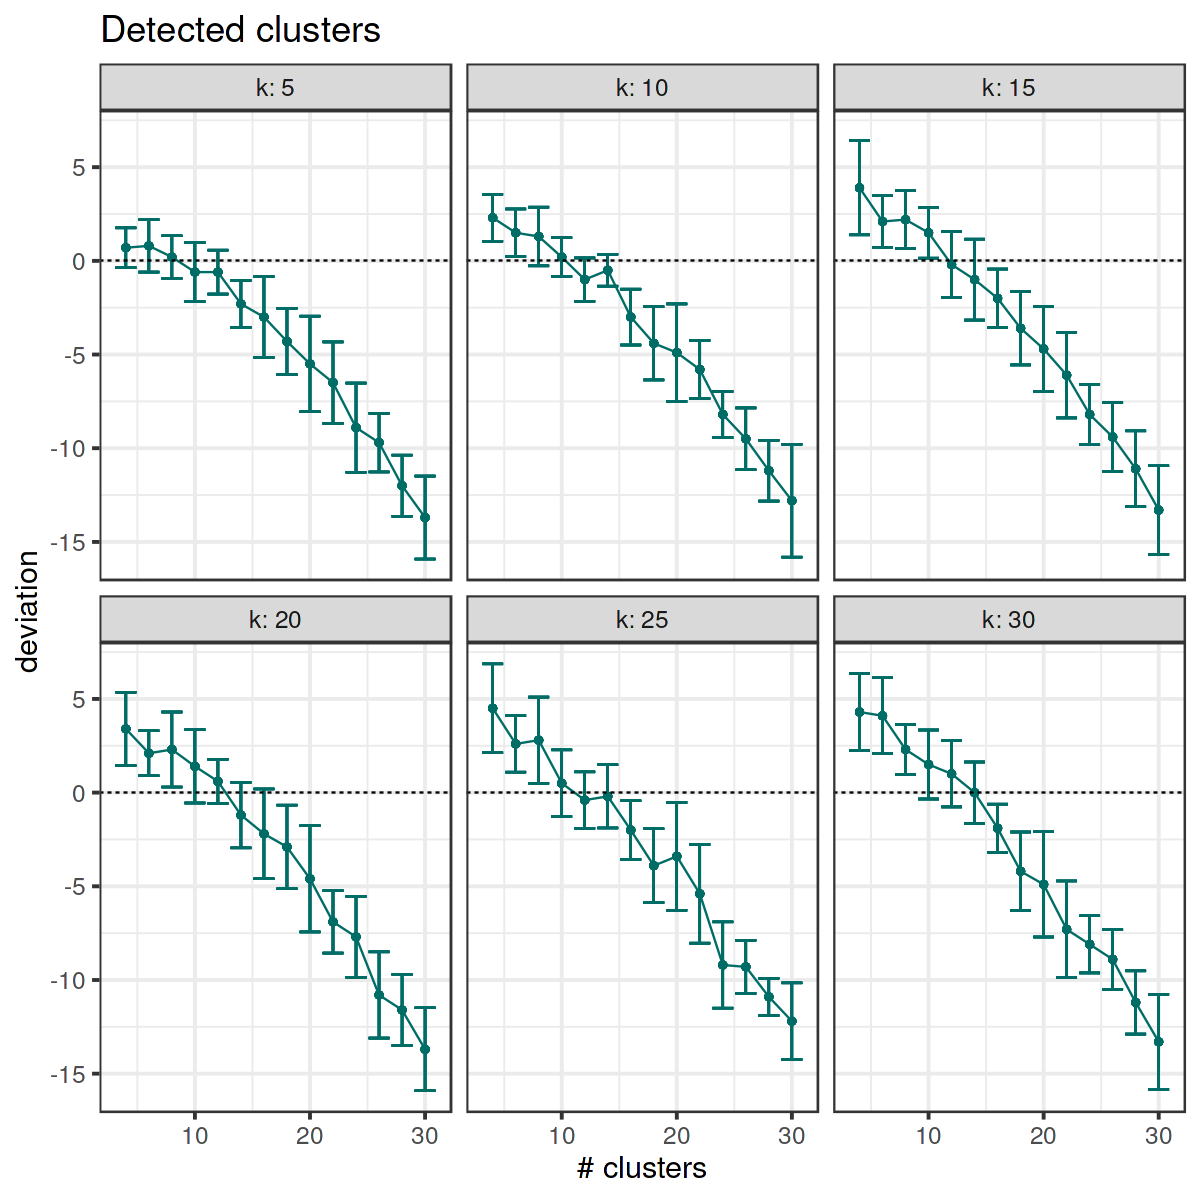

In [30]:
devp_single <- res %>% 
  filter(apl_q == 0.9999) %>%
  ggplot(aes(x = nr_cts, y = diff_mean, color = apl_q)) +
  facet_wrap(~k, labeller = label_both) +
  geom_point() +
  geom_errorbar(aes(ymin=diff_mean-diff_sd, ymax=diff_mean+diff_sd)) +
  geom_line() +
  geom_hline(yintercept = 0, linetype = "dashed") +
  labs(x = "# clusters", y = "deviation", title = "Detected clusters") +
  scale_color_mpimg() +
  theme_bw(base_size = 18) +
  theme(legend.position = "none")

devp_single

ggsave(
  filename = file.path(imgdir, "deviation_aplq-09999_detection.pdf"),
  plot = devp_single,
  width = 2200,
  height = 1800,
  units = "px"
)

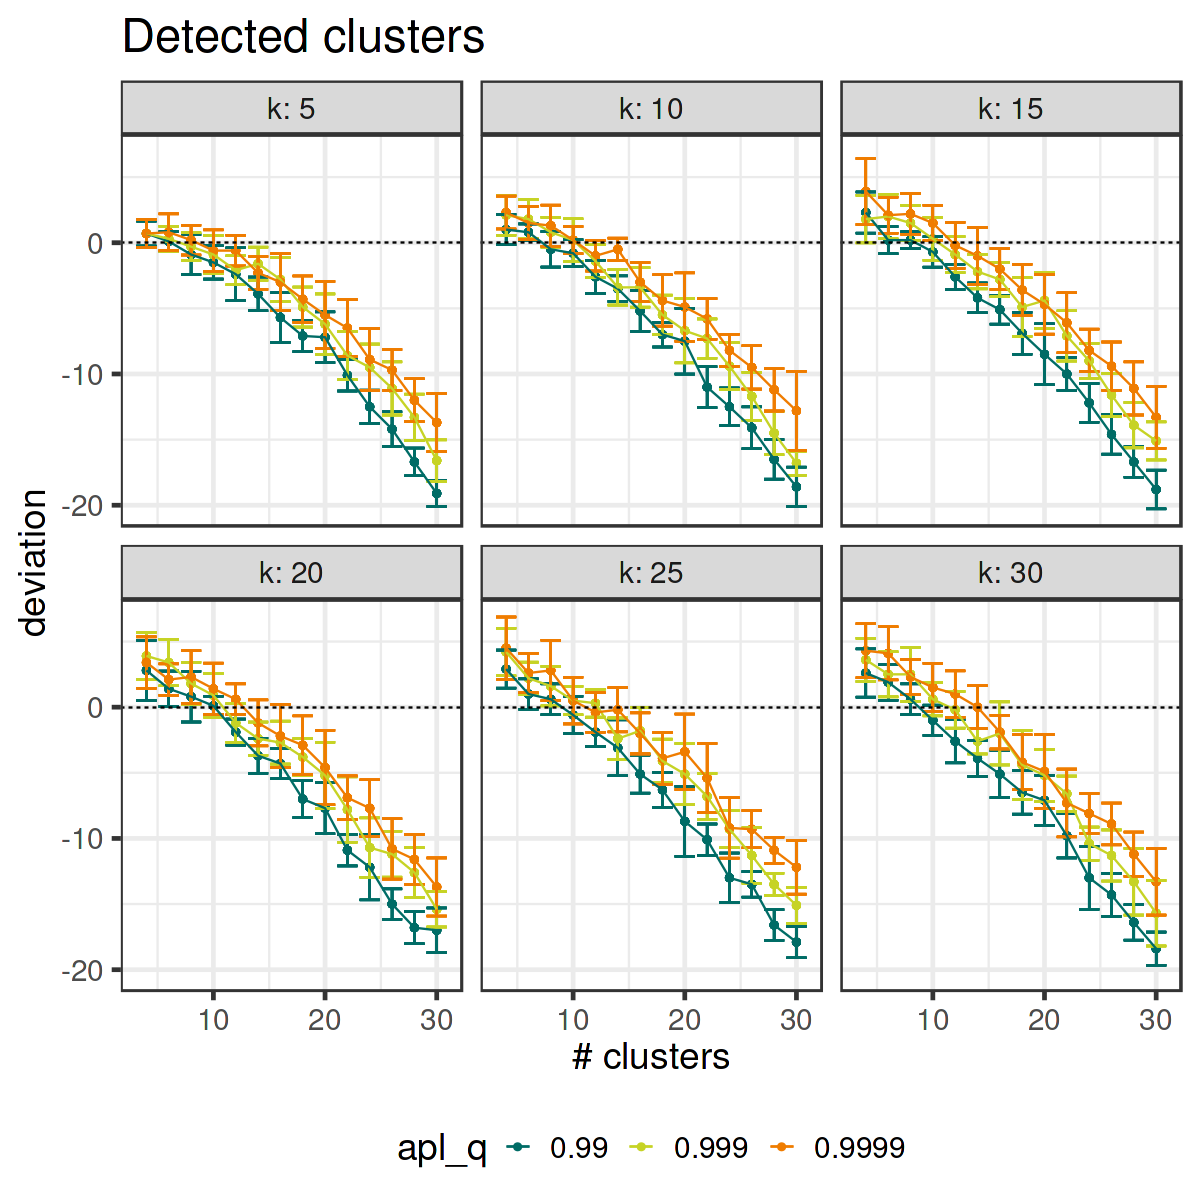

In [31]:
devp <- res %>% 
  ggplot(aes(x = nr_cts, y = diff_mean, color = apl_q)) +
  facet_wrap(~k, labeller = label_both) +
  geom_point() +
  geom_errorbar(aes(ymin=diff_mean-diff_sd, ymax=diff_mean+diff_sd)) +
  geom_line() +
  geom_hline(yintercept = 0, linetype = "dashed") +
  labs(x = "# clusters", y = "deviation", title = "Detected clusters") +
  scale_color_mpimg() +
  theme_bw(base_size = 22) +
  theme(legend.position = "bottom",
        plot.title = element_text(size = 28)
  )

devp

ggsave(
  filename = file.path(imgdir, "deviation_detection.pdf"),
  plot = devp,
  width = 3000,
  height = 2400,
  units = "px"
)

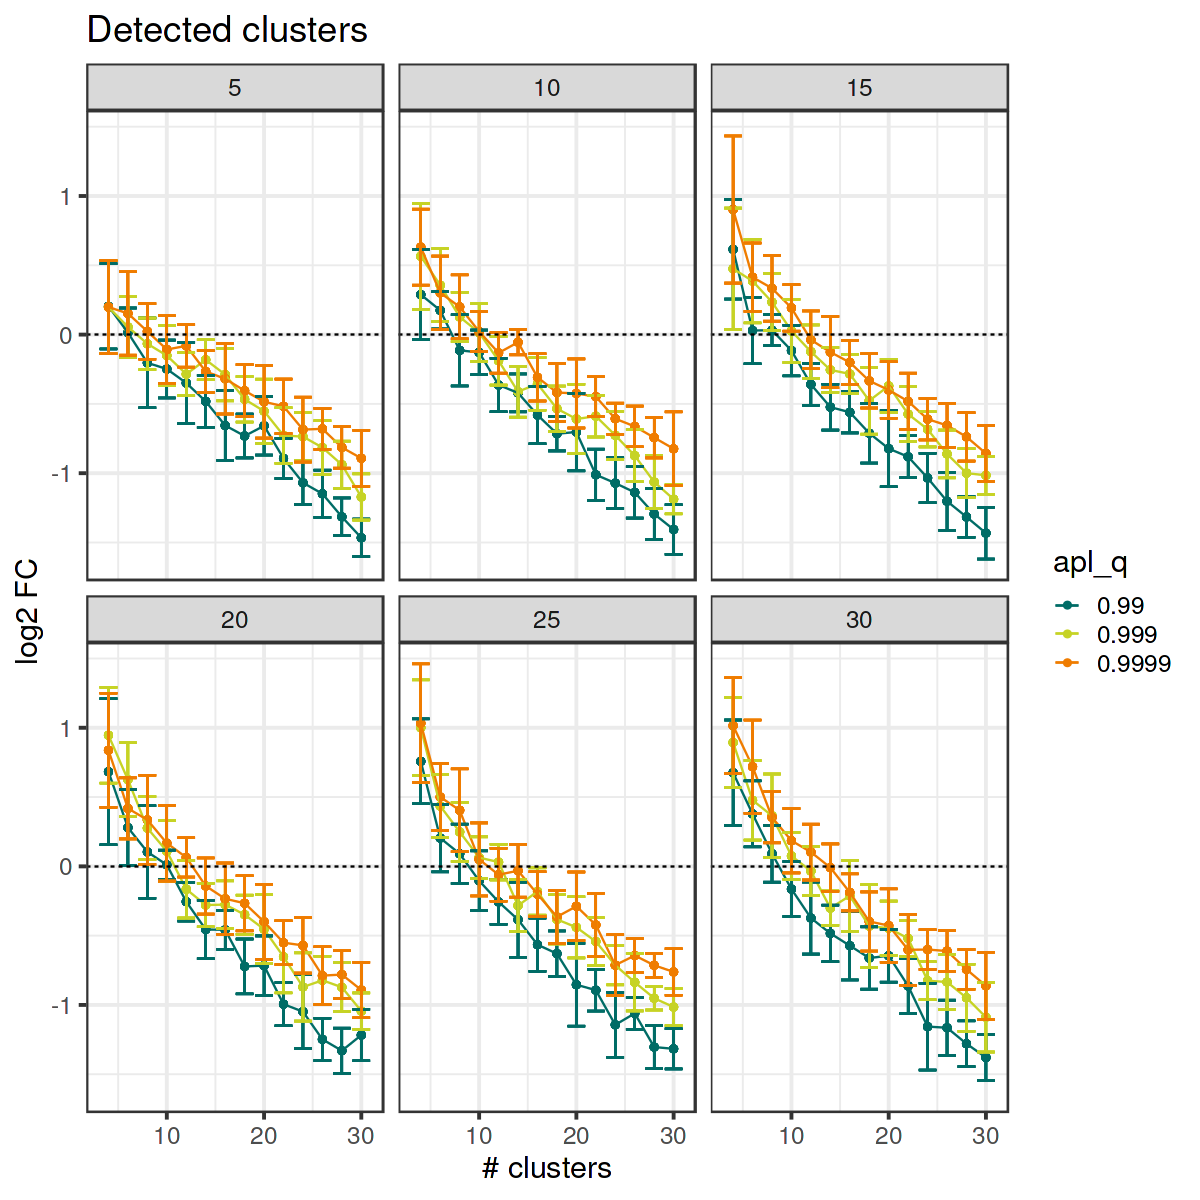

In [32]:
log2fc <- res %>% 
  # filter(apl_q == 0.9999) %>%
  ggplot(aes(x = nr_cts, y = log2fc_mean, color = apl_q)) +
  facet_wrap(~k) +
  geom_point() +
  geom_line() +
  geom_errorbar(aes(ymin=log2fc_mean-log2fc_sd, ymax=log2fc_mean+log2fc_sd)) +
  geom_hline(yintercept = 0, linetype = "dashed") +
  labs(x = "# clusters", y = "log2 FC", title = "Detected clusters") +
  scale_color_mpimg() +
  theme_bw(base_size = 18)

log2fc

ggsave(
  filename = file.path(imgdir, "log2fc_ct_detection.pdf"),
  plot = log2fc,
  width = 2800,
  height = 1800,
  units = "px"
)

## Comparison 30 clusters

The following package(s) are missing entries in the cache:
- quarto
These packages will need to be reinstalled.

The following package(s) have broken symlinks into the cache:
- quarto
Use `renv::repair()` to try and reinstall these packages.

- The project is out-of-sync -- use `renv::status()` for details.


ℹ Loading CAdir



Using 50 dimensions.



Inferred cutoff angle: 64.81

Iteration 1
	Merging cluster_3 with cluster_6
• 	Merging cluster_3 with cluster_23
• 	Merging cluster_3 with cluster_28
	Merging cluster_3 with cluster_11
	Merging cluster_3 with cluster_15
	Merging cluster_3 with cluster_17
	Merging cluster_4 with cluster_7
• 	Merging cluster_4 with cluster_11
	Merging cluster_6 with cluster_10
• 	Merging cluster_6 with cluster_21
	Merging cluster_7 with cluster_9
• 	Merging cluster_7 with cluster_16
	Merging cluster_10 with cluster_17
	Merging cluster_12 with cluster_14
Iteration 2
	Splitting cluster cluster_11
	Merging cluster_2 with cluster_7
	Merging cluster_2 with cluster_10
Iteration 3
	Splitting cluster cluster_15
	Merging cluster_2 with cluster_16
Iteration 4
	Splitting cluster cluster_15
	Merging cluster_2 with cluster_16
Iteration 5
	Splitting cluster cluster_15
	Merging cluster_2 with cluster_16
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale f

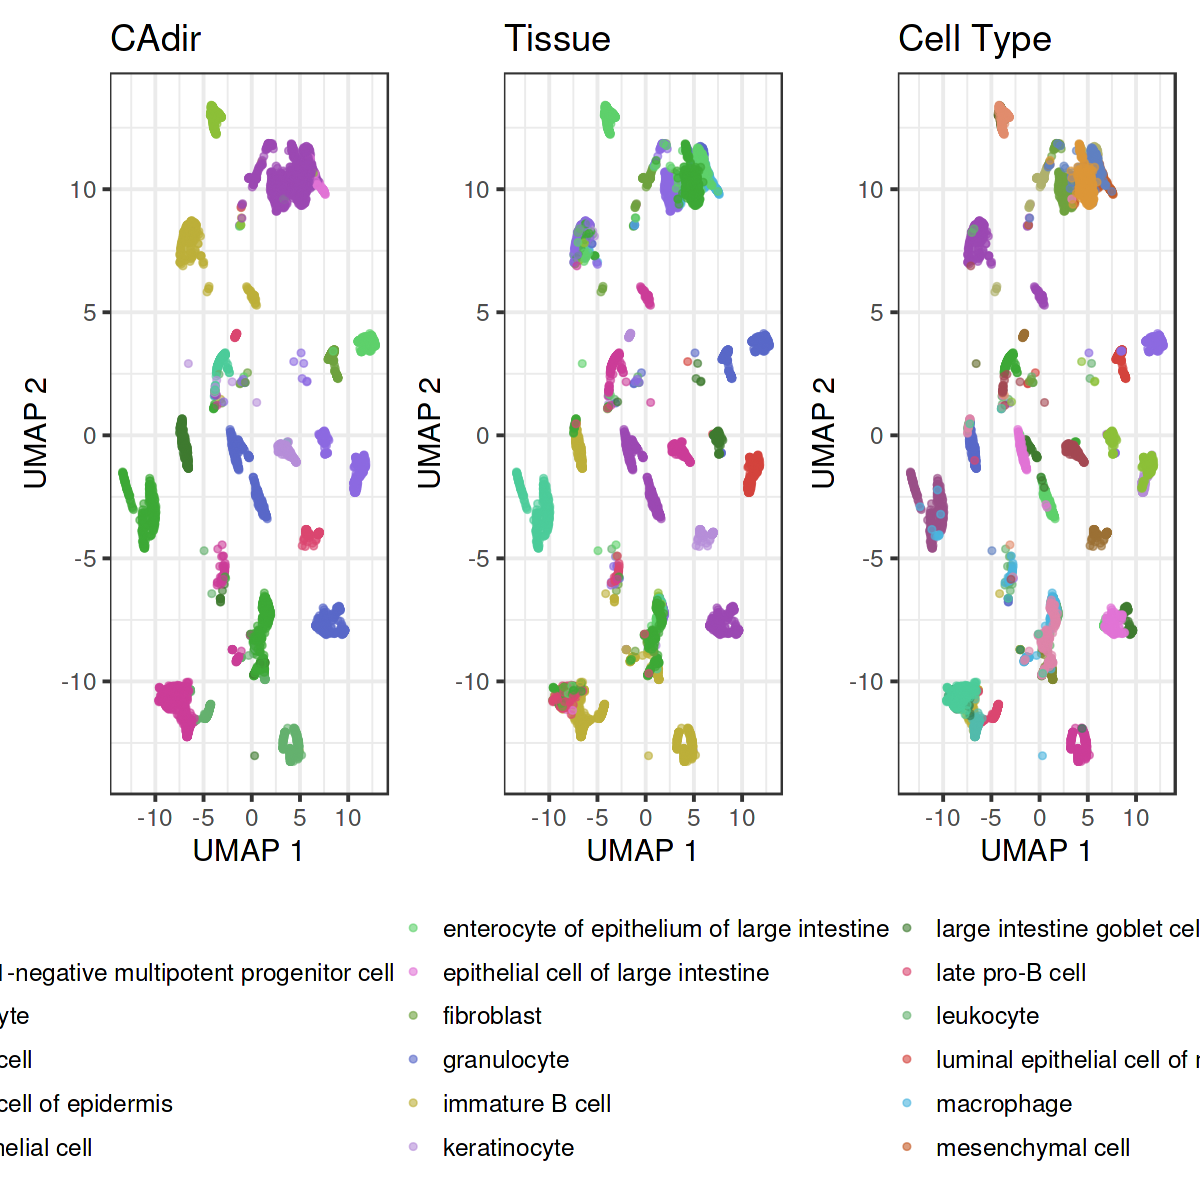

In [33]:
source("./cluster_tabula_muris.R")

large_palette <- c(
                   "#4bcb99",
                   "#cc3d98",
                   "#3ca836",
                   "#8d69e1",
                   "#8dbf38",
                   "#9c48b3",
                   "#5dd06b",
                   "#e173d6",
                   "#6ea23f",
                   "#5967c8",
                   "#bcaf39",
                   "#b68ed9",
                   "#3e7a2f",
                   "#db4670",
                   "#64b06f",
                   "#d4443c",
                   "#4ab4dd",
                   "#c55a25",
                   "#5f80c1",
                   "#dc9737",
                   "#994f88",
                   "#7f882f",
                   "#de84a8",
                   "#33815a",
                   "#a34852",
                   "#52bbac",
                   "#e18d6d",
                   "#606727",
                   "#afb16c",
                   "#9b7035"
)

p1 <- plotUMAP(sce_sub, colour_by = "cadir") +
  scale_color_manual(values = large_palette) +
  ggtitle("CAdir") +
  theme_bw(base_size = 18) +
  theme(legend.position = "bottom") +
  theme(legend.title = element_blank())
p2 <- plotUMAP(sce_sub, colour_by = "tissue") +
  scale_color_manual(values = large_palette) +
  ggtitle("Tissue") +
  theme_bw(base_size = 18) +
  theme(legend.position = "bottom") +
  theme(legend.title = element_blank())
p3 <- plotUMAP(sce_sub, colour_by = "cell_ontology_class") +
  scale_color_manual(values = large_palette) + 
  ggtitle("Cell Type") +
  theme_bw(base_size = 18) +
  theme(legend.position = "bottom") +
  theme(legend.title = element_blank())

comb_umap <- p1+p2+p3
comb_umap

ggsave(
  filename = file.path(imgdir, "tabula_muris_30_clusters.png"),
  plot = comb_umap,
  width = 11500,
  height = 4000,
  units = "px"
)

# Environment

In [34]:
sessionInfo()

R version 4.4.0 (2024-04-24)
Platform: x86_64-pc-linux-gnu
Running under: MarIuX64 2.0 GNU/Linux

Matrix products: default
BLAS:   /pkg/R-4.4.0-0/lib/R/lib/libRblas.so 
LAPACK: /usr/lib/liblapack.so.3.10.1

locale:
 [1] LC_CTYPE=en_US.UTF-8 LC_NUMERIC=C         LC_TIME=C           
 [4] LC_COLLATE=C         LC_MONETARY=C        LC_MESSAGES=C       
 [7] LC_PAPER=C           LC_NAME=C            LC_ADDRESS=C        
[10] LC_TELEPHONE=C       LC_MEASUREMENT=C     LC_IDENTIFICATION=C 

time zone: Europe/Berlin
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] aricode_1.0.3               APL_1.9.1                  
 [3] CAdir_0.0.99                ggthemes_5.1.0             
 [5] readr_2.1.5                 tidyr_1.3.1                
 [7] dplyr_1.1.4                 scater_1.32.0              
 [9] ggplot2_3.5.1               scuttle_1.14.0             
[11] SingleCe